<a href="https://colab.research.google.com/github/pritampanda15/Molecular-Dynamics/blob/master/thefluidisonthelayer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup and libraries

In [ ]:
%%capture
!pip install ase

import numpy as np
import matplotlib.pyplot as plt
import collections
import glob
from ase import Atoms
from ase.io import read
from ase.build import molecule
from ase.collections import g2
from ase.visualize.plot import plot_atoms
from google.colab import files

# Basic definitions

## Plot inside colab

In [ ]:

def plot(structure, rot='45x,45y,30z'):
  fig, ax = plt.subplots(figsize=(10, 8))
  plot_atoms(structure, ax, rotation=str(rot))
  plt.show()

## H$_x$O

In [ ]:
def SingleMolecule(mol):
  mol = mol.lower()

  #------------
  #     H2O
  #------------
  if mol == 'h2o':
    water = Atoms('OH2',
                  positions = [[0.57710052, 0.46538227, 1.],
                               [1.67552173, 0.48890523, 1.],
                               [0.32447827, 1.534661773, 1.]],
                  charges = [-0.8476,
                             0.4238, 
                             0.4238,],
                  masses = [15.999,
                            1.0078,
                            1.0078]
                  )
    return water

  #-------------
  #     OH3
  #-------------
  elif mol == 'oh3':
    oh3 = Atoms('OH3', 
                positions = [[1.000045, 0.763688, 1.148465],
                             [1.000045, 1.708936, 0.851535],
                             [1.818653, 0.291064, 0.851535],
                             [0.181347, 0.291064, 0.851535]],
                charges = [-0.87, 
                           0.29,
                           0.29,
                           0.29],
                masses = [15.999,
                          1.0078,
                          1.0078,
                          1.0078])
    return oh3

  #------------
  #     OH
  #------------
  elif mol == 'oh':
    oh = Atoms('OH', 
               positions =[[1.15615685, 1., 1.],
                           [0.48384314, 1. ,1.]],
               charges = [-0.4238,
                          0.4238],
               masses = [15.999,
                         1.0078]
               )
    return oh


## Graphene

In [ ]:
def graphene(a = 2.468, h=0, z=100):
  """
  a = parametro de rede
  h = posição Z da camada de grafeno
  z = tamanho da caixa de simulação na direção Z 
  """
  graphene = Atoms('C4',
                   positions = [
                                #grafeno
                                [a*0.0, a*0.0, h],
                                [a*0.5, a*np.sqrt(3)/6, h],
                                [a*0.5, a*np.sqrt(3)/2, h],
                                [a*0., a*2*np.sqrt(3)/3, h]
                                ],
                   charges = [0, 0, 0, 0,],
                   masses = [12.0107,12.0107,12.0107,12.0107],
                   cell=[
                         [a*1, 0, 0],
                         [0., a*np.sqrt(3), 0],
                         [0., 0., z]
                         ])
  return graphene

## Fill

In [ ]:
def fill(structure, fillup=1, seed=10):

  np.random.seed(seed)

  #Molecules and charge
  charges = {"H2O": [-0.8476, 0.4238, 0.4238], 
             "Na": [+1],
             "Cl": [-1],
             "OH": [-0.42381, 0.42381],
             "OH3": [-0.87, 0.29, 0.29, 0.29]
             }
             
  molecules = list(charges)
  #Probabilities of molecules            
  probs = [0.84, 
           0.04, 
           0.04, 
           0.04, 
           0.04
           ]

  #length of x
  xmin, xmax = np.min(structure.get_positions()[:,0]), np.max(structure.get_positions()[:,0]) 
  lx =  xmax - xmin 

  #length of y
  ymin, ymax = np.min(structure.get_positions()[:,1]), np.max(structure.get_positions()[:,1]) 
  ly =  ymax - ymin   

  #high
  zmax, z = np.unique(structure.get_positions()[:,2])[-2], structure.get_cell()[2,2]
  h = z- zmax

  #Unit cell
  #a,b,c = 3.4, 3.4, 3.4
  a,b,c = 2.991, 2.991, 2.991

  # Simulation box size:
  # a*nx, b*ny, c*nz
  nx, ny, nz = int(lx/a), int(ly/b), int(h*fillup/c)

  #Molecular base
  base = Atoms()

  #get tag for molecules
  count_tag = np.max(np.unique(structure.get_tags())) + 1
 
  #rotation angle
  rotation = np.arange(0,360, 15)

  molecules_selected = []

  #Begin Loop
  for xi in range(nx):
    for yi in range(ny):
      for zi in range(nz):

        #Select ions/molecules
        ions = np.random.choice(molecules, p=probs)
        molecules_selected.append(ions)



        #Creating ions/molecules
        if ions in ["H2O", "OH", "OH3"]:
          mol = SingleMolecule(str(ions))        
        else:
          mol = molecule(str(ions))

        
        #Setting charges
        mol.set_initial_charges(charges[str(ions)])
        
        #Rotation
        ang = np.random.choice(rotation, 3)
        ang1, ang2, ang3 = ang[0], ang[1], ang[2]
       
        #set cell   
        mol.set_cell([a,b,c])
        #molecule rotation 
        mol.euler_rotate(ang1, ang2, ang3)
        mol.center()
        #translation
        mol.translate([a*xi, b*yi, zmax+5.5+c*zi])
        
        #add  tag
        count_tag += 1
        mol.set_tags(int(count_tag))
        
        base.extend(mol)

  #adding molecules     
  structure.extend(base)
  
  #checking
  print(collections.Counter(molecules_selected))
  plt.hist(molecules_selected)
  plt.show()
  
  return structure

## Select Ions to remove

In [ ]:
def remove_ions(structure, ion1, ion2):
  count_atoms = collections.Counter(structure.get_chemical_symbols())
  
  if count_atoms[str(ion1)] > count_atoms[str(ion2)]:
    n_remove = count_atoms[str(ion1)] - count_atoms[str(ion2)]
    ion = str(ion1)
  else:
    n_remove = count_atoms[str(ion2)] - count_atoms[str(ion1)]
    ion = str(ion2)
  
  ions_to_remove = []
  for i in structure:
    if i.symbol == ion:
      ions_to_remove.append(i.index)
  
  del ions_to_remove[n_remove:]
  return ions_to_remove

## Remove Ions

In [ ]:
def remove(structure, atoms_to_remove):
  count = 0
  for i in atoms_to_remove:
    del structure[i-count]
    count += 1

# System 

## Importing xyz

In [ ]:
#importing xyz files
layers = []

if len(glob.glob('*.xyz')) == 0:
  
  upload_files = files.upload()
  
  for file in glob.glob('*.xyz'):
    layers.append(file)

else:
  
  for file in glob.glob('*.xyz'):
    layers.append(file)

Saving Ai-cubic.xyz to Ai-cubic.xyz
Saving Aln3nm.xyz to Aln3nm.xyz
Saving GaNcubic.xyz to GaNcubic.xyz


In [ ]:
layers

['Aln3nm.xyz', 'GaNcubic.xyz', 'Ai-cubic.xyz']

## Building system

### Layer

In [ ]:
#-------------------
#Creating layer
#-------------------
layer = read(layers[0])

#Creating supercell
layer = layer.repeat([2,2,1])

#setting tag
layer.set_tags(1)

#Redefining unit cell
cell = layer.get_cell()
cell[2][2] = 2*cell[2][2]

#set new unit cell
layer.set_cell(cell)

In [ ]:
#Set charges
if 'Ga' in np.unique(layer.symbols):
  for i in layer:
    if i.symbol == "Ga":
      i.charge = +3
    elif i.symbol == "N":
      i.charge = -3
elif 'Al' in np.unique(layer.symbols):
  for i in layer:
    if i.symbol == "Al":
      i.charge = +0.32
    elif i.symbol == "N":
      i.charge = -0.32
elif "Si" in np.unique(layer.symbols):
  for i in layer:
    i.charge = 0

### Graphene

In [ ]:
#-------------------
#Creating Graphene
#-------------------
gr = graphene()

#Graphene's repetition
ax = int(cell[0][0]/2.468)
ay = int(cell[1][1]/(2.468*np.sqrt(3)))

#Supercell
gr = gr.repeat([ax,ay,1])

#Redefinig unit cell
gr.set_cell(cell)

gr.center()
gr.translate([0,0,cell[2][2]/2 + 5])

#Setting tag
gr.set_tags(2)

layer.extend(gr)

### Water and ions

Counter({'H2O': 5291, 'OH3': 271, 'Na': 256, 'OH': 242, 'Cl': 240})


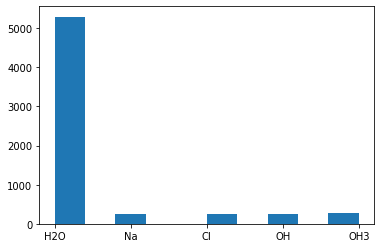

Atoms(symbols='C1500H11637Al1920Cl240N1920Na256O5804', pbc=True, cell=[62.571759224000004, 65.02648544339999, 56.0678215026], initial_charges=..., initial_magmoms=..., masses=..., tags=...)

In [ ]:
#Fill with water and ions
fill(layer, seed=10)

### Make it neutral

In [ ]:
## Remove extra ions
NaCl = remove_ions(layer, 'Na', 'Cl')
remove(layer, NaCl)

Counter({'H': 11637, 'O': 5804, 'N': 1920, 'Al': 1920, 'C': 1500, 'Cl': 240, 'Na': 240})


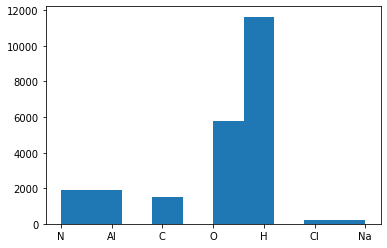

-4.263256414560601e-14


In [ ]:
#Checkin if the system is neutral
print(collections.Counter(layer.get_chemical_symbols()))
plt.hist(layer.get_chemical_symbols())
plt.show()

print(np.sum(layer.get_initial_charges()))

In [ ]:
#plot(layer.repeat([2,2,1]),rot='0x,0y,0z')
#plot(layer)

## Write Lammmps

### Function to write

In [ ]:
def write_lammps(structure):
  
  #Arquivos auxiliares
  c = open('coordinates.dat', mode='w')
  b = open('bonds.dat', mode='w')
  a = open('angles.dat', mode='w')
  #Arquivo Principal
  f = open('system.data', mode='w')

  c.write("""\nAtoms \n\
\n""")
  b.write("""\nBonds \n\
\n""")
  a.write("""\nAngles \n\
\n""")
  

  count_bonds = 1
  count_angles = 1

  if 'Ga' in np.unique(structure.symbols):
    #Escrevendo
    for i in structure:

      #Selecionando os átomos
      if i.tag == 1: #layer
        if i.symbol == "Ga":
          atm_type = 1
        elif i.symbol == "N":
          atm_type = 2

      elif i.tag == 2: #Graphene
        atm_type = 3 #C

      #Ions
      elif i.symbol == "Na":
        atm_type = 4 #Na
      elif i.symbol == "Cl":
        atm_type = 5 #Cl
    
      #--------------------------
      # H2O
      #--------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.4238:
        atm_type = 6 #H H2O
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.8476:
        atm_type = 7 #O H2O

        #--------------------------
        #     Ligações
        #--------------------------
            #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1
      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  1,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1


      #--------------------------
      # OH3
      #--------------------------

      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.29:
        atm_type = 8 #H OH3
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.87:
        atm_type = 9 #O OH3

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1

        #ID #Type #O #H3
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+4))
        count_bonds += 1

      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1

        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+3, 
                                                  i.index+1,
                                                  i.index+4))
        count_angles += 1

      #-------------------------------
      # OH
      #-------------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == +0.42381:
        atm_type = 10 #H OH 
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.42381:
        atm_type = 11 #O OH 

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              3,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
   
      #-----------------------------------
      # Escrevendo as coordenadas atomicas
      #-----------------------------------
      #ID #MOL #ATM #CHARGE #X #Y #Z
      c.write("""{0} {1} {2} {3} {4} {5} {6}\n""".format(i.index+1, 
                                                         i.tag, 
                                                         atm_type,
                                                         i.charge,
                                                         i.position[0],
                                                         i.position[1],
                                                         i.position[2]))
 

    f.write("""#H2O + membranes \n\
\n\
{0}   atoms \n\
{1}   bonds  \n\
{2}   angles \n\
\n""".format(len(structure),
             count_bonds-1,
             count_angles-1))
    
    f.write("""11    atom types \n\
3    bond types \n\
2    angle types \n\
\n""")
    
    f.write("""0.0 {0} xlo xhi \n\
0.0 {1} ylo yhi \n\
{2} {3} zlo zhi \n\
\n""".format(structure.get_cell()[0][0],
             structure.get_cell()[1][1],
             np.min(structure.get_positions()[:,2]),
             np.max(structure.get_positions()[:,2]+100)))
    
    f.write("""Masses \n\
\n\
1 69.723   # Ga layer \n\
2 14.006   # N layer \n\
3 12.010   # C graphene \n\
4 22.989   # Na ion \n\
5 35.453   # Cl ion \n\
6 1.007    # H H2O \n\
7 15.999   # O H2O \n\
8 1.007    # H OH3 \n\
9 15.999   # O OH3 \n\
10 1.007    # H OH \n\
11 15.999   # O OH \n\
\n""")
  elif "Al" in np.unique(structure.symbols):
    #Escrevendo
    for i in structure:

      #Selecionando os átomos
      if i.tag == 1: #layer
        if i.symbol == "Al":
          atm_type = 1
        elif i.symbol == "N":
          atm_type = 2

      elif i.tag == 2: #Graphene
        atm_type = 3 #C

      #Ions
      elif i.symbol == "Na":
        atm_type = 4 #Na
      elif i.symbol == "Cl":
        atm_type = 5 #Cl
    
      #--------------------------
      # H2O
      #--------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.4238:
        atm_type = 6 #H H2O
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.8476:
        atm_type = 7 #O H2O

        #--------------------------
        #     Ligações
        #--------------------------
            #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1
      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  1,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1


      #--------------------------
      # OH3
      #--------------------------

      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.29:
        atm_type = 8 #H OH3
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.87:
        atm_type = 9 #O OH3

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1

        #ID #Type #O #H3
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+4))
        count_bonds += 1

      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1

        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+3, 
                                                  i.index+1,
                                                  i.index+4))
        count_angles += 1

      #-------------------------------
      # OH
      #-------------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == +0.42381:
        atm_type = 10 #H OH 
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.42381:
        atm_type = 11 #O OH 

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              3,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
   
      #-----------------------------------
      # Escrevendo as coordenadas atomicas
      #-----------------------------------
      #ID #MOL #ATM #CHARGE #X #Y #Z
      c.write("""{0} {1} {2} {3} {4} {5} {6}\n""".format(i.index+1, 
                                                         i.tag, 
                                                         atm_type,
                                                         i.charge,
                                                         i.position[0],
                                                         i.position[1],
                                                         i.position[2]))
 

    f.write("""#H2O + membranes \n\
\n\
{0}   atoms \n\
{1}   bonds  \n\
{2}   angles \n\
\n""".format(len(structure),
             count_bonds-1,
             count_angles-1))
    
    f.write("""11    atom types \n\
3    bond types \n\
2    angle types \n\
\n""")
    
    f.write("""0.0 {0} xlo xhi \n\
0.0 {1} ylo yhi \n\
{2} {3} zlo zhi \n\
\n""".format(structure.get_cell()[0][0],
             structure.get_cell()[1][1],
             np.min(structure.get_positions()[:,2]),
             np.max(structure.get_positions()[:,2]+100)))
    
    f.write("""Masses \n\
\n\
1 26.9815   # Al layer \n\
2 14.006   # N layer \n\
3 12.010   # C graphene \n\
4 22.989   # Na ion \n\
5 35.453   # Cl ion \n\
6 1.007    # H H2O \n\
7 15.999   # O H2O \n\
8 1.007    # H OH3 \n\
9 15.999   # O OH3 \n\
10 1.007    # H OH \n\
11 15.999   # O OH \n\
\n""")
  elif "Si" in np.unique(structure.symbols):
    for i in structure:

      #Selecionando os átomos
      if i.tag == 1: #layer
        if i.symbol == "Si":
          atm_type = 1

      elif i.tag == 2: #Graphene
        atm_type = 2 #C

      #Ions
      elif i.symbol == "Na":
        atm_type = 3 #Na
      elif i.symbol == "Cl":
        atm_type = 4 #Cl
    
      #--------------------------
      # H2O
      #--------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.4238:
        atm_type = 5 #H H2O
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.8476:
        atm_type = 6 #O H2O

        #--------------------------
        #     Ligações
        #--------------------------
            #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              1,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1
      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  1,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1


      #--------------------------
      # OH3
      #--------------------------

      elif i.tag > 2 and i.symbol == "H" and i.charge == 0.29:
        atm_type = 7 #H OH3
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.87:
        atm_type = 8 #O OH3

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H1
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
      
        #ID #Type #O #H2
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+3))
        count_bonds += 1

        #ID #Type #O #H3
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              2,
                                              i.index+1,
                                              i.index+4))
        count_bonds += 1

      
        #---------------------
        #       Angulos
        #---------------------
        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+2, 
                                                  i.index+1,
                                                  i.index+3))
        count_angles += 1

        #ID #Type #H1 #O #H2
        a.write("""{0} {1} {2} {3} {4}\n""".format(count_angles,
                                                  2,
                                                  i.index+3, 
                                                  i.index+1,
                                                  i.index+4))
        count_angles += 1

      #-------------------------------
      # OH
      #-------------------------------
      elif i.tag > 2 and i.symbol == "H" and i.charge == +0.42381:
        atm_type = 9 #H OH 
      elif i.tag > 2 and i.symbol == "O" and i.charge == -0.42381:
        atm_type = 10 #O OH 

        #--------------------------
        #     Ligações
        #--------------------------
        #ID #Type #O #H
        b.write("""{0} {1} {2} {3}\n""".format(count_bonds,
                                              3,
                                              i.index+1,
                                              i.index+2))
        count_bonds += 1
   
      #-----------------------------------
      # Escrevendo as coordenadas atomicas
      #-----------------------------------
      #ID #MOL #ATM #CHARGE #X #Y #Z
      c.write("""{0} {1} {2} {3} {4} {5} {6}\n""".format(i.index+1, 
                                                         i.tag, 
                                                         atm_type,
                                                         i.charge,
                                                         i.position[0],
                                                         i.position[1],
                                                         i.position[2]))
 

    f.write("""#H2O + membranes \n\
\n\
{0}   atoms \n\
{1}   bonds  \n\
{2}   angles \n\
\n""".format(len(structure),
             count_bonds-1,
             count_angles-1))
    
    f.write("""10    atom types \n\
3    bond types \n\
2    angle types \n\
\n""")
    
    f.write("""0.0 {0} xlo xhi \n\
0.0 {1} ylo yhi \n\
{2} {3} zlo zhi \n\
\n""".format(structure.get_cell()[0][0],
             structure.get_cell()[1][1],
             np.min(structure.get_positions()[:,2]),
             np.max(structure.get_positions()[:,2]+100)))
    
    f.write("""Masses \n\
\n\
1 28.0855   # Si layer \n\
2 12.010   # C graphene \n\
3 22.989   # Na ion \n\
4 35.453   # Cl ion \n\
5 1.007    # H H2O \n\
6 15.999   # O H2O \n\
7 1.007    # H OH3 \n\
8 15.999   # O OH3 \n\
9 1.007    # H OH \n\
10 15.999   # O OH \n\
\n""")    


  #Fechando os arquivos
  c.close()
  b.close()
  a.close()
  f.close()

  # Copy file to another
  with open('coordinates.dat','r') as readfile:
    with open('system.data','a') as writefile:
      for line in readfile:
        writefile.write(line)
  
  # Copy file to another
  with open('bonds.dat','r') as readfile:
    with open('system.data','a') as writefile:
      for line in readfile:
        writefile.write(line)

  # Copy file to another
  with open('angles.dat','r') as readfile:
    with open('system.data','a') as writefile:
      for line in readfile:
        writefile.write(line)

  #Apagando os arquivos auxiliares
  !rm bonds.dat
  !rm angles.dat
  !rm coordinates.dat
  print("Done system.data")

### Lammps input

In [ ]:
write_lammps(layer)

Done system.data


# SCRATCH